# Cross-selling insurance opportunity prediction

The client is an insurance company that has provided health insurance to its customers. They now need your help to build a predictive model that can predict whether last year's policyholders may be interested in purchasing insurance for their vehicle as well.

The dataset consists of the following properties:

- **id**: unique identifier of the policyholder.
- **Gender**: gender of the policyholder.
- **Age**: age of the policyholder. 
- **Driving_License**: 1 if the policyholder has a driving license, 0 otherwise.
- **Region_Code**: unique code for the policyholder's region.
- **Previously_Insured**: 1 if the policyholder already has a vehicle insured, 0 otherwise.
- **Vehicle_Age**: age of the vehicle.
- **Vehicle_Damage**: 1 if the policyholder has damaged the vehicle in the past, 0 otherwise.
- **Annual_Premium**: the amount that the policyholder must pay as a premium during the year.
- **Policy_Sales_Channel**: anonymized code of the channel used for the proposal (e.g. by email, by phone, in person, etc...)
- **Vintage**: number of days the policyholder has been a customer of the company.
- **Response**: 1 if the policyholder responded positively to the sales proposal, 0 otherwise.
The purpose of the model is to predict the value of Response.

Tip: Pay attention to the distribution of the classes. 

### IMPORT LIBRARIES

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (10,8)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### IMPORT DATASET

In [2]:
df = pd.read_csv("train.csv", index_col="id")

In [3]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.shape

(381109, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


### CHECK FOR MISSING VALUES

In [6]:
df.isnull().sum().sum()
#dataset has no missing data

0

In [7]:
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

### DESCRIPTIVE STATISTICS 

In [8]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [9]:
df.describe(include=['object'])

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


### EXPLORATORY DATA ANALYSIS

In [10]:
df.Response.value_counts(normalize=True).round(2)
#the dataset is unbalanced. 

Response
0    0.88
1    0.12
Name: proportion, dtype: float64

In [11]:
df.Gender.value_counts(normalize=True).round(2)

Gender
Male      0.54
Female    0.46
Name: proportion, dtype: float64

In [12]:
df.groupby(['Response'])['Gender'].value_counts(normalize=True).round(2)
#Gender and Response correlation. Ratio for both positive and negative response is almost equal.

Response  Gender
0         Male      0.53
          Female    0.47
1         Male      0.61
          Female    0.39
Name: proportion, dtype: float64

In [13]:
df.groupby(['Vehicle_Damage'])['Gender'].value_counts(normalize=True).round(2)
#Male tends to have more vehicle damage.

Vehicle_Damage  Gender
No              Female    0.51
                Male      0.49
Yes             Male      0.59
                Female    0.41
Name: proportion, dtype: float64

In [14]:
df.groupby(['Vehicle_Damage'])['Response'].value_counts(normalize=True).round(2)
#Owners of damaged vehicles tend to respond positively.

Vehicle_Damage  Response
No              0           0.99
                1           0.01
Yes             0           0.76
                1           0.24
Name: proportion, dtype: float64

In [15]:
df.groupby(['Vehicle_Age'])['Response'].value_counts(normalize=True).round(2)

Vehicle_Age  Response
1-2 Year     0           0.83
             1           0.17
< 1 Year     0           0.96
             1           0.04
> 2 Years    0           0.71
             1           0.29
Name: proportion, dtype: float64

In [16]:
df.groupby('Response')['Previously_Insured'].value_counts(normalize=True).round(2)

Response  Previously_Insured
0         1                     0.52
          0                     0.48
1         0                     1.00
          1                     0.00
Name: proportion, dtype: float64

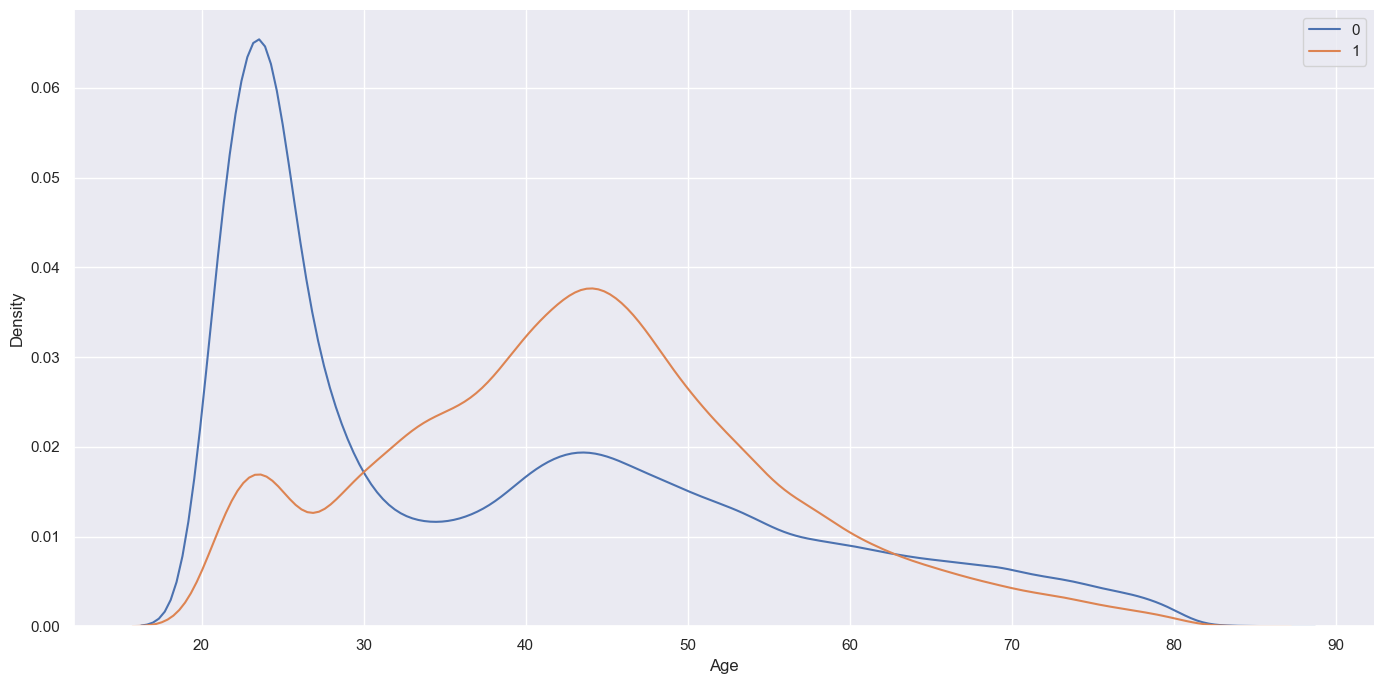

In [17]:
graph1 = sns.FacetGrid(df, hue='Response', height = 7, aspect = 2)
graph1.map(sns.kdeplot, 'Age')
plt.legend()
plt.show()
#Younger people are less interested in insurance

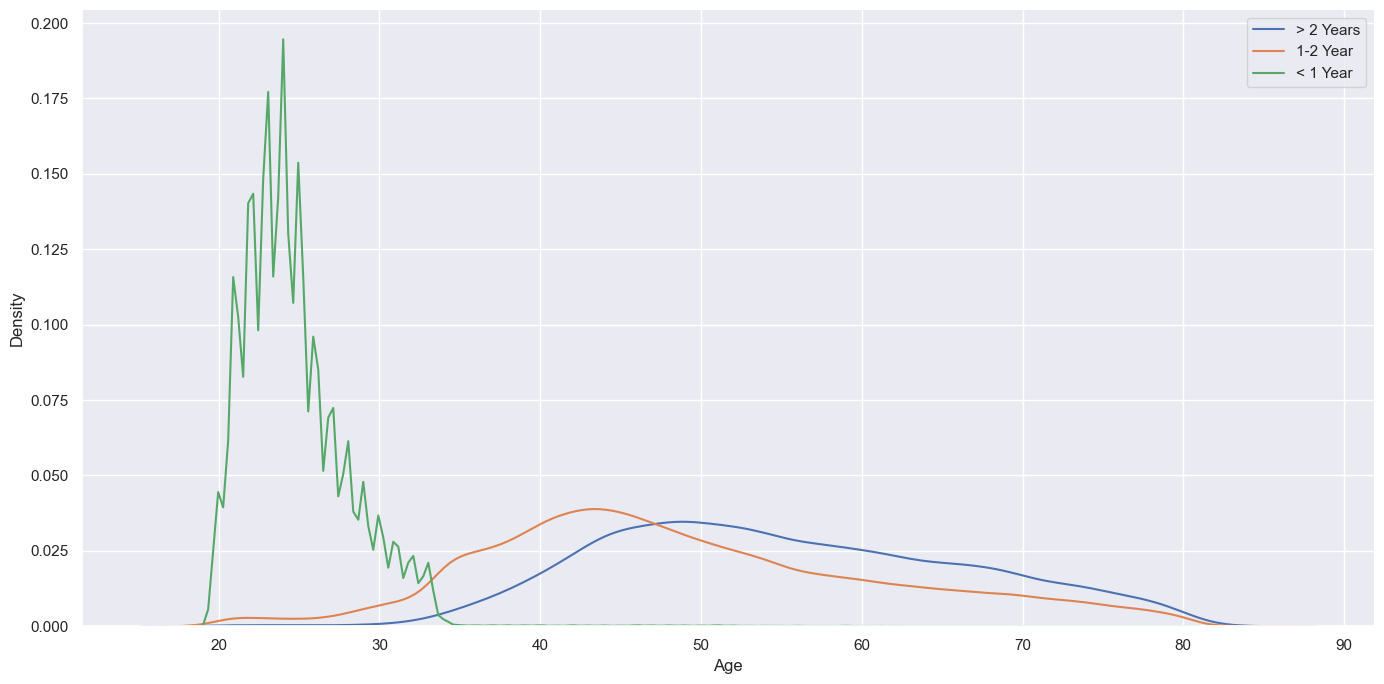

In [18]:
graph2 = sns.FacetGrid(df, hue='Vehicle_Age', height = 7, aspect = 2)
graph2.map(sns.kdeplot, 'Age')
plt.legend()
plt.show()

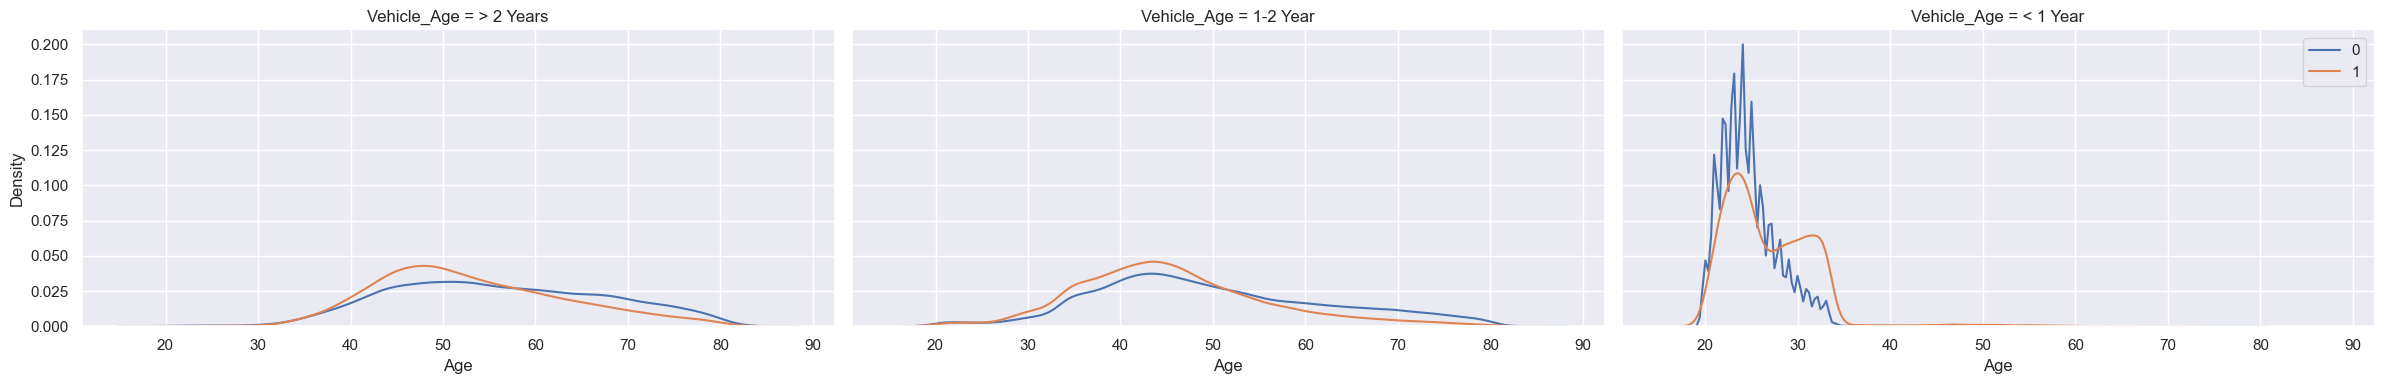

In [19]:
graph3 = sns.FacetGrid(df, col='Vehicle_Age', hue='Response', height = 4, aspect = 2)
graph3.map(sns.kdeplot, 'Age')
plt.legend()
plt.show()

In [20]:
#Conversion of categorical data into numerical data
df.Gender.replace({'Male':1,'Female':2}, inplace=True)
df.Vehicle_Damage.replace({'Yes':1,'No':0}, inplace=True)
df.Vehicle_Age.replace({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3}, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.9 MB


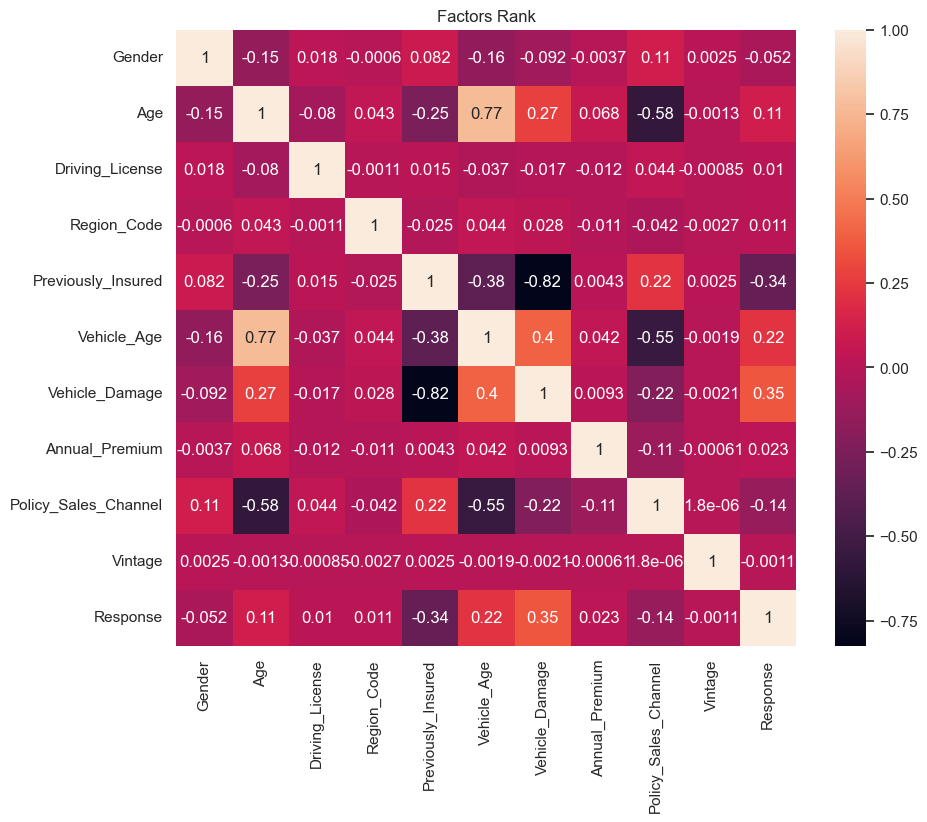

In [22]:
#Correlation between variables
sns.heatmap(df.corr(), annot = True)
plt.title('Factors Rank')
plt.show()


### MODEL SELECTION

In [23]:
#The function generates a confusion matrix and plots a heatmap. 
def plot_confusion_matrix(y_true,y_pred, labels=["Negative","Positive"],show_precision_recall=True):
    
    cm=confusion_matrix(y_true,y_pred)
    df_cm=pd.DataFrame(cm, 
                       index=labels,
                       columns=["Predicted " + labels[0],"Predicted " + labels[1]]
                      )
    plt.figure(figsize=(8, 6))
    hm=sns.heatmap(df_cm/np.sum(cm), annot=True,fmt=".2%")
    
    if show_precision_recall:
        plt.text(0,-0.1,f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.4f}")
        plt.text(1,-0.1,f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.4f}")
    plt.show()

In [24]:
#initialise an empty dictionary in order to resume the evaluation metrics of different models
analysis = {}

In [25]:
#The aim of the function is to select the best classification model. 
#5 variants of the logistic regression model are tested: 
#1) LogR: basic version of the model; 
#2) LogR_ROS_minority: oversampling with sampling strategy: "minority" (randomly duplicates samples from the minority class and adds them to the train set); 
#3) LogR_balanced: class-weight "balanced" (different weights to both the majority and minority classes); 
#4) LogR_RUS_majority: undersampling with sampling strategy: "majority" (randomly delete examples in the majority class); 
#5) LogR_DROP: class-weight "balanced" and drop of two independent variables.
#(Vintage: low correlation with target variable; Vehicle_Age: avoid multicollinearity)
#Models are implemented to handle the unbalanced class and, as in the last case,
#reduce the dimensionality of the dataset too.
#The function divides the data into training and test sets, applies standardisation 
#and returns the main evaluation metrics in the form of a confusion matrix, ROC AUC score 
#and classification report. It also saves precision, recall, f1-score and accuracy for each 
#of the executed models in the empty dictionary (analysis).

In [26]:
def model_selection(df):
    models = {
        'LogR': LogisticRegression(),
        'LogR_ROS_minority': LogisticRegression(),
        'LogR_balanced': LogisticRegression(class_weight='balanced'),
        'LogR_RUS_majority': LogisticRegression(),
        'LogR_DROP': LogisticRegression()
    }
    X=df.drop("Response",axis=1).values
    y=df["Response"].values
    X_train1, X_test1, y_train1, y_test1=train_test_split(X,y,test_size=0.3, random_state=0)
    ss=StandardScaler()
    X_train1=ss.fit_transform(X_train1)
    X_test1=ss.transform(X_test1)
    for model_type, model in models.items():
        if model_type == 'LogR_ROS_minority':
            ros = RandomOverSampler(sampling_strategy="minority", random_state=0)
            X_train, y_train = ros.fit_resample(X_train1, y_train1)
            X_test, y_test=X_test1, y_test1
            model = LogisticRegression()
        elif model_type == 'LogR_RUS_majority':
            rus = RandomUnderSampler(sampling_strategy="majority", random_state=0)
            X_train, y_train = rus.fit_resample(X_train1, y_train1)
            X_test, y_test=X_test1, y_test1
            model = LogisticRegression()
        elif model_type == 'LogR_DROP':
            df_dropped = df.drop(["Vintage", 'Vehicle_Age'], axis=1)
            X_train, X_test, y_train, y_test = train_test_split(
                df_dropped.drop("Response", axis=1).values, df_dropped["Response"].values,
                test_size=0.3, random_state=0)
            ss = StandardScaler()
            X_train = ss.fit_transform(X_train)
            X_test = ss.transform(X_test)
            model = LogisticRegression(class_weight='balanced')
        else:
            X_train, y_train = X_train1, y_train1
            X_test, y_test = X_test1, y_test1
         
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        print(f'{model_type} TRAIN')
        plot_confusion_matrix(y_train, y_pred_train)
        print(f'{model_type} TEST')
        plot_confusion_matrix(y_test, y_pred_test)
        y_pred_proba_train = model.predict_proba(X_train)[:,1]
        y_pred_proba_test = model.predict_proba(X_test)[:,1]
        print()
        print(f'ROC AUC Score (TRAIN): {roc_auc_score(y_train, y_pred_proba_train).round(4)}')
        print(f'ROC AUC Score (TEST): {roc_auc_score(y_test, y_pred_proba_test).round(4)}')
        print()
        print(f'Classification Report: {model_type} TRAIN')
        print(classification_report(y_train, y_pred_train))
        print(f'Classification Report: {model_type} TEST')
        print(classification_report(y_test, y_pred_test))
        
        
        target_names = ['negative', 'positive']
        report = classification_report(y_test, y_pred_test, output_dict=True, target_names=target_names)
        analysis[model_type] = (
            report['positive']['precision'], report['positive']['recall'], 
            report['positive']['f1-score'], report['accuracy']
        )

LogR TRAIN


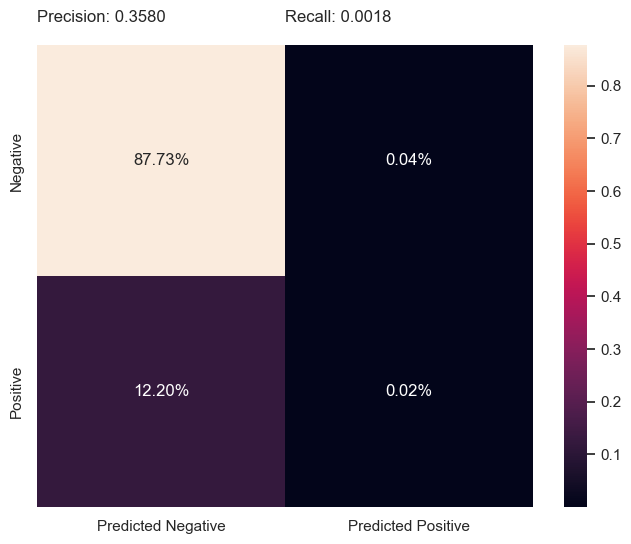

LogR TEST


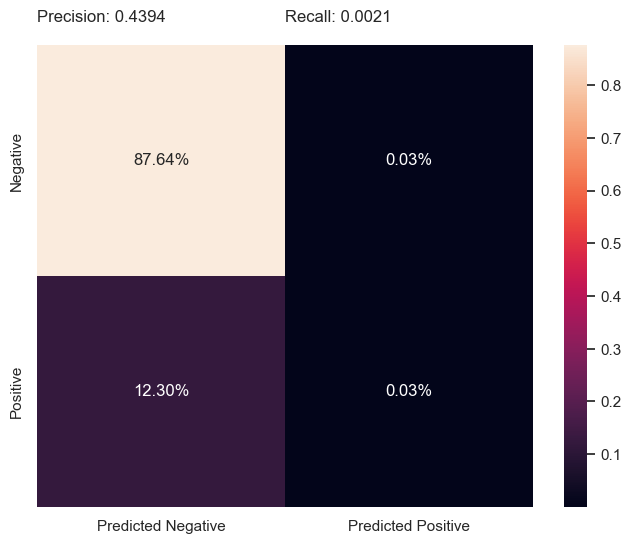


ROC AUC Score (TRAIN): 0.8319
ROC AUC Score (TEST): 0.832

Classification Report: LogR TRAIN
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    234158
           1       0.36      0.00      0.00     32618

    accuracy                           0.88    266776
   macro avg       0.62      0.50      0.47    266776
weighted avg       0.81      0.88      0.82    266776

Classification Report: LogR TEST
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100241
           1       0.44      0.00      0.00     14092

    accuracy                           0.88    114333
   macro avg       0.66      0.50      0.47    114333
weighted avg       0.82      0.88      0.82    114333

LogR_ROS_minority TRAIN


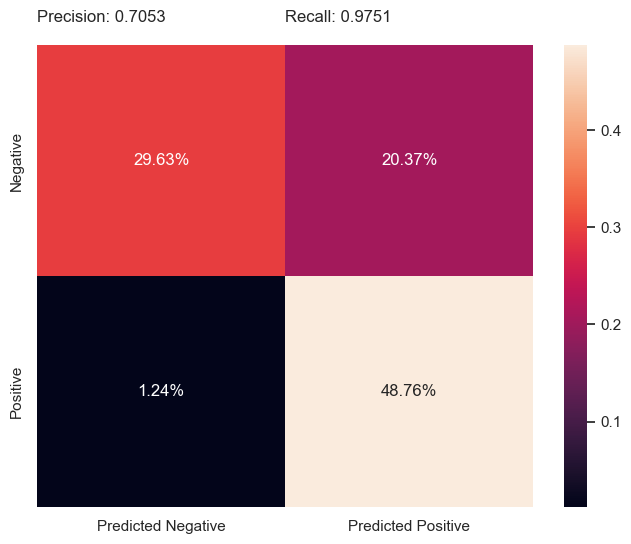

LogR_ROS_minority TEST


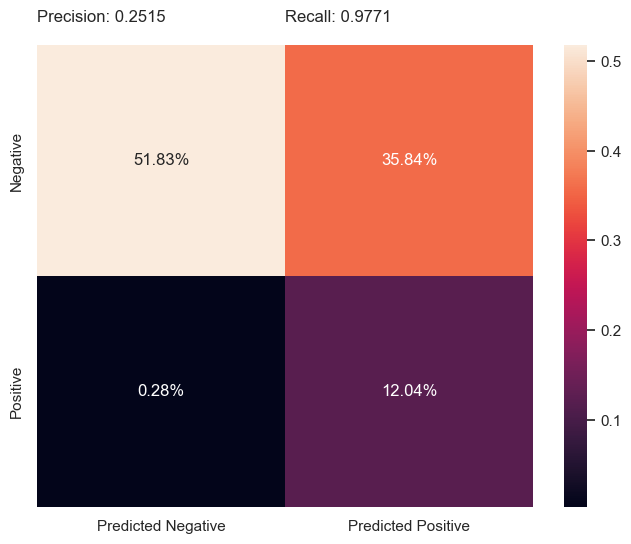


ROC AUC Score (TRAIN): 0.8324
ROC AUC Score (TEST): 0.8322

Classification Report: LogR_ROS_minority TRAIN
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234158
           1       0.71      0.98      0.82    234158

    accuracy                           0.78    468316
   macro avg       0.83      0.78      0.78    468316
weighted avg       0.83      0.78      0.78    468316

Classification Report: LogR_ROS_minority TEST
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

LogR_balanced TRAIN


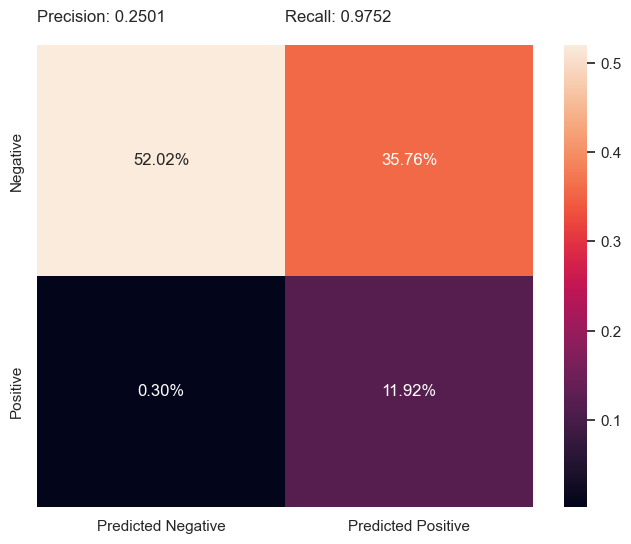

LogR_balanced TEST


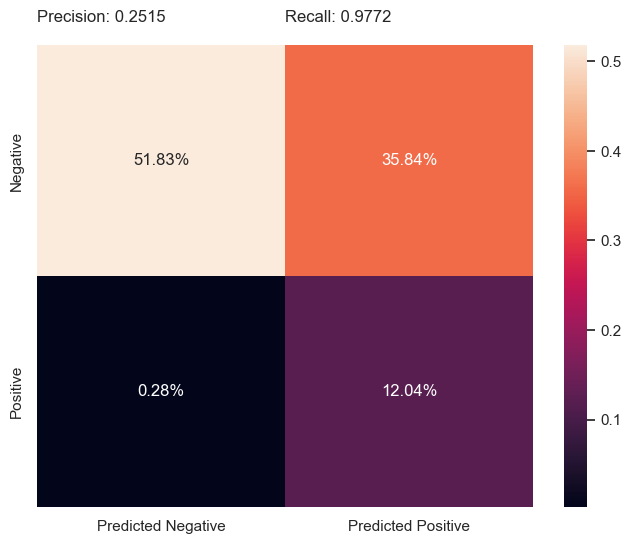


ROC AUC Score (TRAIN): 0.832
ROC AUC Score (TEST): 0.8322

Classification Report: LogR_balanced TRAIN
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234158
           1       0.25      0.98      0.40     32618

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Classification Report: LogR_balanced TEST
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

LogR_RUS_majority TRAIN


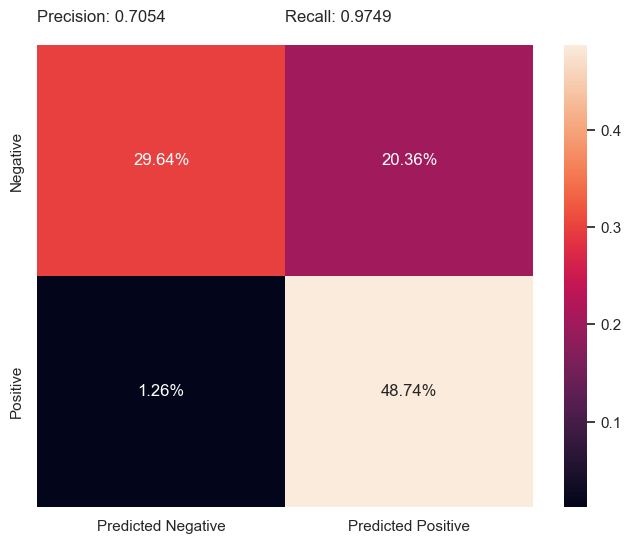

LogR_RUS_majority TEST


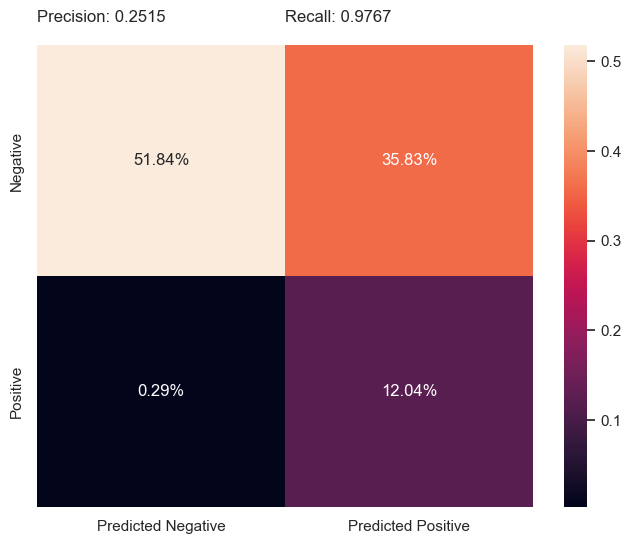


ROC AUC Score (TRAIN): 0.8334
ROC AUC Score (TEST): 0.8321

Classification Report: LogR_RUS_majority TRAIN
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     32618
           1       0.71      0.97      0.82     32618

    accuracy                           0.78     65236
   macro avg       0.83      0.78      0.78     65236
weighted avg       0.83      0.78      0.78     65236

Classification Report: LogR_RUS_majority TEST
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

LogR_DROP TRAIN


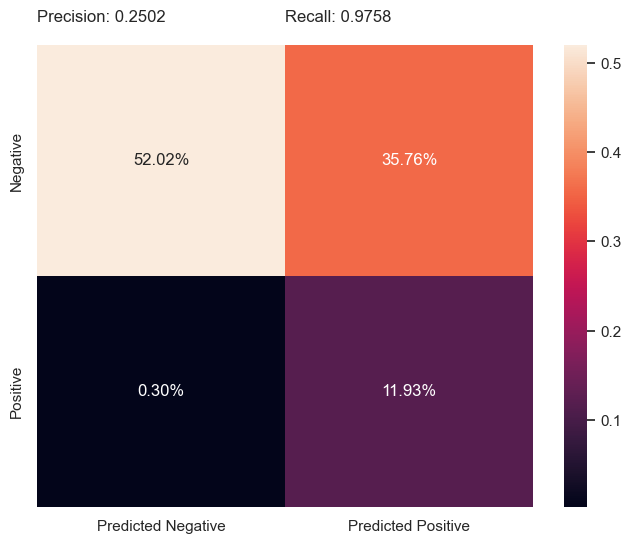

LogR_DROP TEST


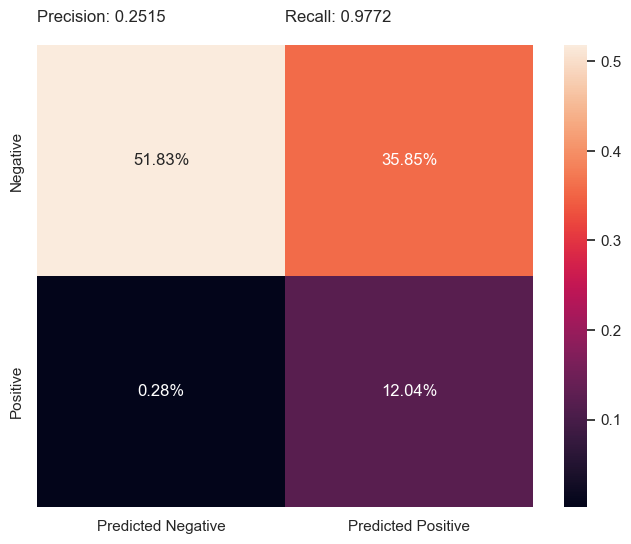


ROC AUC Score (TRAIN): 0.8163
ROC AUC Score (TEST): 0.8165

Classification Report: LogR_DROP TRAIN
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234158
           1       0.25      0.98      0.40     32618

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Classification Report: LogR_DROP TEST
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



In [27]:
model_selection(df)

In [28]:
#Accuracy indicates the percentage of correct predictions out of the total 
#number of predictions. However, in an unbalanced dataset, the model may 
#have a high accuracy even though it cannot correctly predict the minority class. 
#Therefore, this metric may be misleading in the presence of class imbalance.
#Precision indicates the model's ability to correctly identify true positives out 
#of the total number of positives predicted by the model. This metric is particularly 
#important when the aim is to minimise false positives.
#Recall indicates the model's ability to identify all true positives out of the total 
#number of true positives in the data. This metric is particularly important when the 
#goal is to minimise false negatives.
#Therefore, to evaluate the performance of a model on an unbalanced dataset, 
#it is important to consider precision, recall and accuracy together.
#In our case, an important metric is recall, since it is best for the company to minimise 
#false negative predictions and not lose potential interested clients.

In [29]:
analysis=pd.DataFrame.from_dict(analysis)
analysis.index= ['Precision', 'Recall', 'F1_score','Accuracy']
analysis

,LogR,LogR_ROS_minority,LogR_balanced,LogR_RUS_majority,LogR_DROP
Precision,0.439394,0.251489,0.251498,0.251475,0.251498
Recall,0.002058,0.977079,0.977150,0.976653,0.977221
F1_score,0.004097,0.400017,0.400035,0.399965,0.400041
Accuracy,0.876676,0.638739,0.638739,0.638818,0.638722


In [30]:
#LogR is a model with the typical problems of unbalanced datasets: high accuracy 
#due to the fact that it predicts all data as the majority class because 
#it does not have enough information to learn the pattern of the minority class, 
#which is why precision and recall are very low.
#The other models using unbalance compensation techniques all exhibit more or less 
#the same precision, recall (hence f1-score) and accuracy values.
#In these models, accuracy is around 0.64 (compared to LogR's 0.88), while recall 
#rises to 0.98 and precision drops to 0.24. As explained before, it is better 
#to focus on recall rather than precision because it is better to contact an 
#uninterested client than to lose an interested one.
#ROC AUC score does not seem to be much affected by the type of model selected.
#This is why i would opt for the model that not only compensates the unbalance but 
#also reduces the dataset (LogR_DROP).

In [31]:
df=df.drop(["Vintage",'Vehicle_Age'],axis=1)
X=df.drop("Response",axis=1).values
y=df["Response"].values
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=0)
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')